## **Capstone Project 24.1: Final Report**

### Research Question: Could ML analysis effectively distinguish between spam and ham messages to enhance spam filtering systems?

In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
from collections import Counter
import string
import nltk
import re
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud
import sklearn
sklearn.metrics.accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier, PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from IPython.display import display, HTML
import nltk
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words("english")
nltk.download('punkt')
nltk.download('wordnet')

!pip install wordcloud

Matplotlib is building the font cache; this may take a moment.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/72b73498-2dcf-429e-ad08-
[nltk_data]     c45dcec8a34e/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/72b73498-2dcf-429e-ad08-
[nltk_data]     c45dcec8a34e/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/72b73498-2dcf-429e-ad08-
[nltk_data]     c45dcec8a34e/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Defaulting to user installation because normal site-packages is not writeable
Looking in links: /usr/share/pip-wheels


In [3]:
conda install -c conda-forge wordcloud=1.6.0 

Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: / warning  libmamba Added empty dependency for problem type SOLVER_RULE_UPDATE
failed

LibMambaUnsatisfiableError: Encountered problems while solving:
  - package wordcloud-1.6.0-py27h516909a_0 requires python >=2.7,<2.8.0a0, but none of the providers can be installed

Could not solve for environment specs
The following packages are incompatible
├─ pin-1 is installable and it requires
│  └─ python 3.11.* , which can be installed;
└─ wordcloud 1.6.0**  is not installable because there are no viable options
   ├─ wordcloud 1.6.0 would require
   │  └─ python >=2.7,<2.8.0a0 , which conflicts with any installable versions previously reported;
   ├─ wordcloud 1.6.0 would require
   │  └─ python >=3.6,<3.7.0a0 , which conflicts with any installable versions previously reported;
   ├─ wordcloud 1.6.0 would require
   │  └─ python >=3.7,<3.8.0a0 , which conflicts with any installable versions previously reported;
   └

In [7]:
#Load dataset
df = pd.read_csv("spam.csv", encoding = 'latin-1')

In [9]:
# Examine the data
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [11]:
# Drop the null data
df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis = 1, inplace = True)

In [13]:
# Recheck the updated dataset and confirm the null data no longer exists
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
# Rename the columns with more meaningful descriptions 
df.columns = ["class", "message"]

In [17]:
# Check updated dataset
df.head()

,class,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [25]:
# Add a new column  named "len" to the dataframe based on the length of the "message" column
df["len"] = [len(text) for text in df.message]

In [27]:
# Perform grouped summary statistics operation on the dataframe
df.groupby("class").describe()

len                                                         
        count        mean        std   min    25%    50%    75%    max
class                                                                 
ham    4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0
spam    747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0

### [Analysis] It appears that the messages in the "spam" class are longer than those in the "ham" class. Additionally, there are fewer spam messages compared to ham messages, indicating a noticeable class imbalance in our data. We acknowledge the need to address this imbalance, but we will tackle this issue in our subsequent pre-processing steps.

In [30]:
# Calculate the percentage distribution of the unique values in the "class" column in relation to the total number of rows in the dataframe
df["class"].value_counts()/df["class"].shape[0]*100

class
ham     86.593683
spam    13.406317
Name: count, dtype: float64

In [32]:
# Recheck dataframe
df.head()

,class,message,len
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [34]:
# Use the Natural Language toolkit to create a list of English stopwords
stopword_list = nltk.corpus.stopwords.words("english")

In [36]:
# Assign function to variable named 'tokener'
tokener = nltk.word_tokenize

In [38]:
# Create dictionary to store the most common word and its count for each message in the "message" column of the dataframe
common_words = {"word": [], "count": []}

for word in df["message"]:
    tok = tokener(word)
    m_counter = Counter(tok)
    common_words["word"].append(m_counter.most_common(1)[0][0])
    common_words["count"].append(m_counter.most_common(1)[0][1])

In [40]:
# Create new dataframe containing the columns from the original and 2 additional columns, "word" and "count" derived from the "common_words" dictionary
common_words_df = pd.concat([df, pd.DataFrame(common_words)], axis = 1)

In [42]:
# Generate word cloud visualization based on the most common words stored in the "word" column of the "common_words_df" dataframe
import wordcloud
words_cloud = wordcloud.WordCloud().generate_from_text(' '.join(common_words_df["word"]))

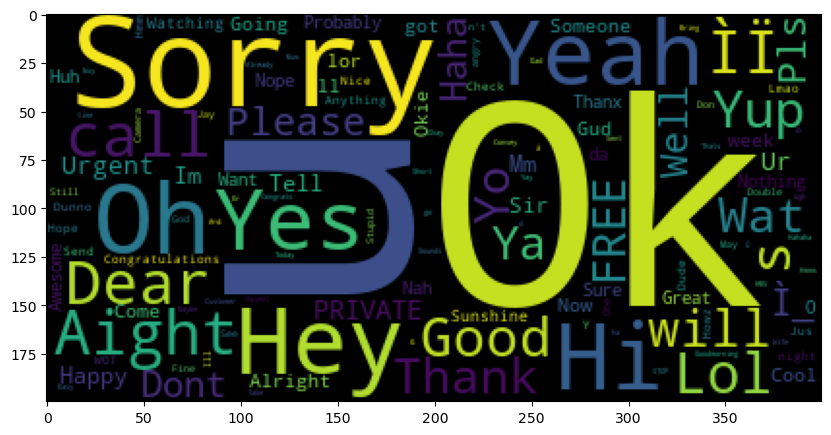

In [44]:
# Display the resulting wordcloud
plt.figure(figsize=(10,6))
plt.imshow(words_cloud)

In [46]:
# Remove the "len" column
df = df.drop("len", axis = 1)

In [48]:
# View updated dataframe
df.head()

,class,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [50]:
# Convert all text in the "message" column to lowercase
df.message = df.message.apply(str.lower)

In [52]:
# Replace whitespace characters with single space
def remove_whitespace(text):
    clean_words = re.sub(r'\s+', ' ', text)
    return clean_words.strip()
df.message = df.message.apply(remove_whitespace)

In [54]:
# Remove punctuation from the text
def remove_punch(text):
    rm_punch = text.translate(str.maketrans("", "", string.punctuation))
    return rm_punch
df.message = df.message.apply(remove_punch)

In [56]:
# Defines new function "remove_stopwords" that takes a text as input, tokenizes it using a tokenizer named "tokener", and removes stopwords from the tokenized words using a list of stopwords named "stopword_list". 
def remove_stopwords(text):
    tok_words = tokener(text)
    clean_words = [word for word in tok_words if word.lower() not in stopword_list]
    cleaned_text = ' '.join(clean_words)
    return cleaned_text

In [58]:
# Remove stopwords from each text entry in the "message" column
df.message = df.message.apply(remove_stopwords)

In [59]:
# Create 2 dataframes by filtering original dataframe "df" base on the values in the "class" column
ham_class = df[df["class"] == "ham"]
spam_class = df[df["class"] == "spam"]

In [62]:
# Concatenate all the text messages in the "message" column for each class into 2 separate strings
ham_text = ' '.join(ham_class.message)
spam_text = ' '.join(spam_class.message)

In [64]:
# Create word clouds for the "ham" and "spam" classes
ham_wordcloud = wordcloud.WordCloud().generate_from_text(ham_text)
spam_wordcloud = wordcloud.WordCloud().generate_from_text(spam_text)

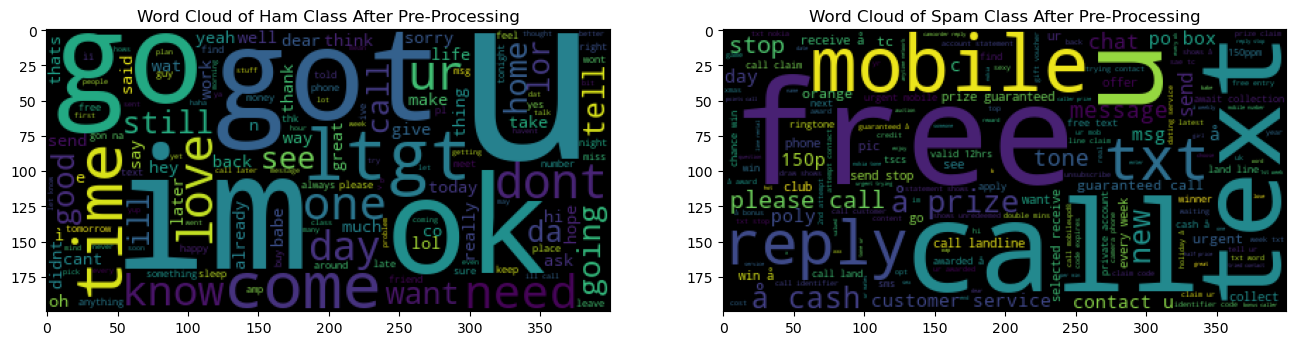

In [65]:
# Generate the respective wordcloud images
plt.figure(figsize=(16,12))
plt.subplot(121)
plt.title("Word Cloud of Ham Class After Pre-Processing")
plt.imshow(ham_wordcloud)
plt.subplot(122)
plt.title("Word Cloud of Spam Class After Pre-Processing")
plt.imshow(spam_wordcloud)

In [68]:
# Define function to remove all numeric characters in the text messages
def remove_digits(text):
    clean_text = str(text).translate(str.maketrans("", "", string.digits))
    return clean_text

In [70]:
# Apply the "remove_digits" function to the "message" column of the dataframe
df.message = df.message.apply(remove_digits)

In [72]:
# Define function to remove all consecutive spaces in the text messages and replace them with single space
def remove_extraspace(text):
    clean_text = re.sub(r"\s+", " ", text)
    return clean_text

In [74]:
# Apply the "remove_extraspace" function to the "message" column of the dataframe
df.message = df.message.apply(remove_extraspace)

In [76]:
# Create "lm" object to lemmatize words in text data
lm = nltk.WordNetLemmatizer()

In [78]:
# Define "lemma" function to convert words in a text to their base / root form
def lemma(text):
    tok_word = tokener(text)
    lemma_word = []
    for tok in tok_word:
        lemma_tok = lm.lemmatize(tok)
        lemma_word.append(lemma_tok)
    return ' '.join(lemma_word)

In [80]:
# Apply the "lemma" function to the "message" column of the dataframe
df["lemma_message"] = df.message.apply(lemma)

In [82]:
# Examine updated dataframe
df.head(5)

,class,message,lemma_message
0,ham,go jurong point crazy available bugis n great ...,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni,ok lar joking wif u oni
2,spam,free entry wkly comp win fa cup final tkts st ...,free entry wkly comp win fa cup final tkts st ...
3,ham,u dun say early hor u c already say,u dun say early hor u c already say
4,ham,nah dont think goes usf lives around though,nah dont think go usf life around though


In [84]:
# Create updated dataframe containing only the index and "lemma_message" columns
final_df = df.iloc[:, [0, 2]]

In [86]:
print(df['lemma_message'])

0       go jurong point crazy available bugis n great ...
1                                 ok lar joking wif u oni
2       free entry wkly comp win fa cup final tkts st ...
3                     u dun say early hor u c already say
4                nah dont think go usf life around though
                              ...                        
5567    nd time tried contact u u å£ pound prize claim...
5568                          ì b going esplanade fr home
5569                           pity mood soany suggestion
5570    guy bitching acted like id interested buying s...
5571                                       rofl true name
Name: lemma_message, Length: 5572, dtype: object


In [88]:
# Create proper feature "X" and target "y" variables
X = df.iloc[:, 1]
y = df.iloc[:, 0]

In [90]:
# Create an instance to convert categorical labels into binary vectors
lb = LabelBinarizer()

In [92]:
# Fit transform y labels into binary vectors
scaled_y = lb.fit_transform(y)

In [94]:
# Create object to transform text into sparse matrix of TF-IDF features
tf_idf = TfidfVectorizer(ngram_range=(1,3))

In [96]:
# Fit transform x labels into matrix of TF-IDF features
scaled_x = tf_idf.fit_transform(X)

In [97]:
# Create an instance of cross-validation with 10 folds to create
kfold= StratifiedKFold(n_splits= 10)

In [100]:
# Compute accuracy classification score
sklearn.metrics.accuracy_score

<function sklearn.metrics._classification.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)>

In [102]:
# Define new evaluation function for the binary classification model; uses various metrics to assess the performance of the model on both the training & testing datasets
def evaluate_model(y_train, y_test, y_train_predict, y_test_predict):
    
    print("*******Accuracy*******\n")
    
    train_accuracy = sklearn.metrics.accuracy_score(y_train, y_train_predict)
    test_accuracy = sklearn.metrics.accuracy_score(y_test, y_test_predict)
    
    print("Train Accuracy: %s" %(train_accuracy))
    print("Test Accuracy: %s" %(test_accuracy))
    
    train_error = 1-train_accuracy
    test_error = 1-test_accuracy
    
    print("\n")
    print("Train Error: %s" %(train_error))
    print("Test Error: %s" %(test_error))
    
    print("\n******* F1-Score **********")
    
    train_f1_score = sklearn.metrics.f1_score(y_train, y_train_predict)
    test_f1_score = sklearn.metrics.f1_score(y_test, y_test_predict)
    
    print("\n")
    print("Train F1-Score: %s" %(train_f1_score))
    print("Test F1-Score: %s" %(test_f1_score))
    
    print("\n********* Log Loss ***********")
    train_log_loss = sklearn.metrics.log_loss(y_train, y_train_predict)
    test_log_loss = sklearn.metrics.log_loss(y_test, y_test_predict)
    
    print("\n")
    print("Train Log Loss: %s" %(train_log_loss))
    print("Test Log Loss: %s" %(test_log_loss))
    
    print("\n********* Classification Report *********")
    train_cf_report = pd.DataFrame(sklearn.metrics.classification_report(y_train, y_train_predict, output_dict = True))
    test_cf_report = pd.DataFrame(sklearn.metrics.classification_report(y_test, y_test_predict, output_dict = True))
    
    print("\n")
    print("Train Classification Report:")
    print(train_cf_report)
    print("Test Classification Report:")
    print(test_cf_report)
    
    print("\n********* F-Beta Score ********")
    train_fbeta_score = sklearn.metrics.fbeta_score(y_train, y_train_predict, beta = 0.5)
    test_fbeta_score = sklearn.metrics.fbeta_score(y_test, y_test_predict, beta = 0.5)
    
    print("\n")
    print("Train FBeta Score: %s" %(train_fbeta_score))
    print("Test FBeta Score: %s" %(test_fbeta_score))
    
    print("\n******** Confustion Matrix *********")
    train_conf_mtx = sklearn.metrics.confusion_matrix(y_train, y_train_predict)
    test_conf_mtx = sklearn.metrics.confusion_matrix(y_test, y_test_predict)
    
    print("\n")
    print("Train Confusion Matrix:")
    print(train_conf_mtx)
    print("Test Confusion Matrix:")
    print(test_conf_mtx)

## Models Evaluation:
- Split data into training & testing sets for each iteration
- Train each model on training set (x-train and y_train)
- Make predictions on both the training and testing sets
- Compute accuracy and F1 scores for both sets

### 1) Logistic Regression

In [106]:
# Logistic Regression
lr_train_accuracy = []
lr_test_accuracy = []
lr_train_f1_score = []
lr_test_f1_score = []

for train_idx, test_idx in kfold.split(scaled_x, scaled_y):
    x_train, x_test, y_train, y_test = scaled_x[train_idx], scaled_x[test_idx], scaled_y[train_idx], scaled_y[test_idx]
    lr = LogisticRegression(random_state = 42)
    lr.fit(x_train, y_train)
    train_predict = lr.predict(x_train)
    test_predict = lr.predict(x_test)
    
    train_accu = sklearn.metrics.accuracy_score(y_train, train_predict)
    test_accu = sklearn.metrics.accuracy_score(y_test, test_predict)
    
    train_f1 = sklearn.metrics.f1_score(y_train, train_predict)
    test_f1 = sklearn.metrics.f1_score(y_test, test_predict)
    
    lr_train_accuracy.append(train_accu)
    lr_test_accuracy.append(test_accu)
    lr_train_f1_score.append(train_f1)
    lr_test_f1_score.append(test_f1)

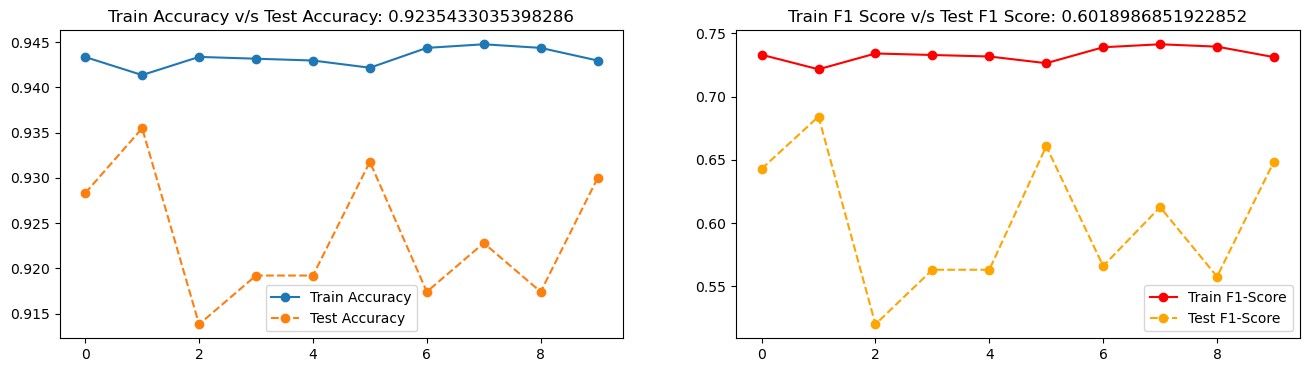

In [107]:
# Compare training & testing accuracy and F1-Score across different folds
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title("Train Accuracy v/s Test Accuracy: %s" %(np.mean(lr_test_accuracy)))
plt.plot(lr_train_accuracy, marker = "o")
plt.plot(lr_test_accuracy, marker = "o", linestyle = "--")
plt.legend(["Train Accuracy", "Test Accuracy"])
plt.subplot(122)
plt.title("Train F1 Score v/s Test F1 Score: %s" %(np.mean(lr_test_f1_score)))
plt.plot(lr_train_f1_score, marker = "o", color = "r")
plt.plot(lr_test_f1_score,  marker = "o", linestyle = "--", color = "orange")
plt.legend(["Train F1-Score", "Test F1-Score"])

### 2) K-Nearest Neighbor

In [111]:
# K-Nearest Neighbor
knn_train_accuracy = []
knn_test_accuracy = []
knn_train_f1_score = []
knn_test_f1_score = []

for train_idx, test_idx in kfold.split(scaled_x, scaled_y):
    x_train, x_test, y_train, y_test = scaled_x[train_idx], scaled_x[test_idx], scaled_y[train_idx], scaled_y[test_idx]
    knn = KNeighborsClassifier()
    knn.fit(x_train, y_train)
    train_predict = knn.predict(x_train)
    test_predict = knn.predict(x_test)
    
    train_accu = sklearn.metrics.accuracy_score(y_train, train_predict)
    test_accu = sklearn.metrics.accuracy_score(y_test, test_predict)
    
    train_f1 = sklearn.metrics.f1_score(y_train, train_predict)
    test_f1 = sklearn.metrics.f1_score(y_test, test_predict)
    
    knn_train_accuracy.append(train_accu)
    knn_test_accuracy.append(test_accu)
    knn_train_f1_score.append(train_f1)
    knn_test_f1_score.append(test_f1)

  File "/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/joblib/externals/loky/backend/context.py", line 217, in _count_physical_cores
    raise ValueError(


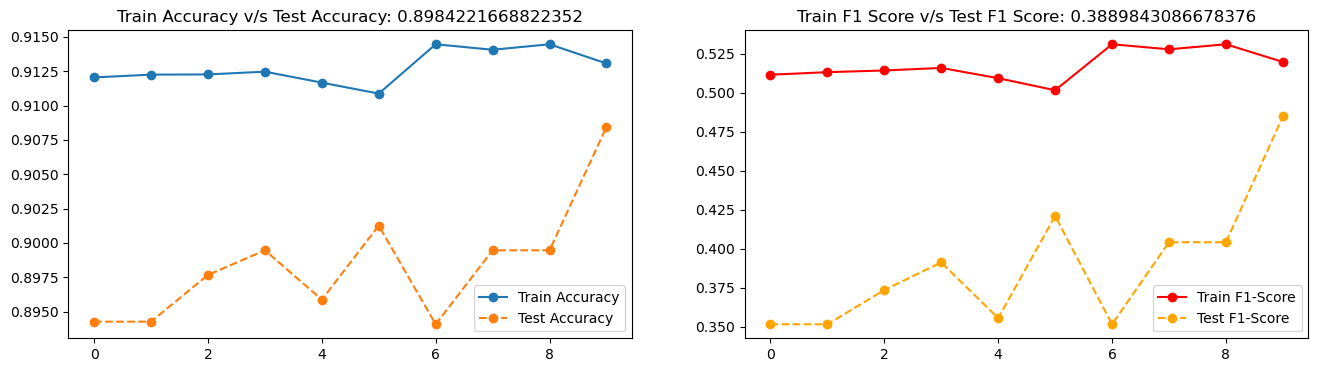

In [112]:
# Compare training & testing accuracy and F1-Score across different folds
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title("Train Accuracy v/s Test Accuracy: %s" %(np.mean(knn_test_accuracy)))
plt.plot(knn_train_accuracy, marker = "o")
plt.plot(knn_test_accuracy, marker = "o", linestyle = "--")
plt.legend(["Train Accuracy", "Test Accuracy"])
plt.subplot(122)
plt.title("Train F1 Score v/s Test F1 Score: %s" %(np.mean(knn_test_f1_score)))
plt.plot(knn_train_f1_score, marker = "o", color = "r")
plt.plot(knn_test_f1_score,  marker = "o", linestyle = "--", color = "orange")
plt.legend(["Train F1-Score", "Test F1-Score"])

### 3) Decision Trees

In [116]:
# Decision Trees
dt_train_accuracy = []
dt_test_accuracy = []
dt_train_f1_score = []
dt_test_f1_score = []

for train_idx, test_idx in kfold.split(scaled_x, scaled_y):
    x_train, x_test, y_train, y_test = scaled_x[train_idx], scaled_x[test_idx], scaled_y[train_idx], scaled_y[test_idx]
    dt = DecisionTreeClassifier(random_state=42)
    dt.fit(x_train, y_train)
    train_predict = dt.predict(x_train)
    test_predict = dt.predict(x_test)
    
    train_accu = sklearn.metrics.accuracy_score(y_train, train_predict)
    test_accu = sklearn.metrics.accuracy_score(y_test, test_predict)
    
    train_f1 = sklearn.metrics.f1_score(y_train, train_predict)
    test_f1 = sklearn.metrics.f1_score(y_test, test_predict)
    
    dt_train_accuracy.append(train_accu)
    dt_test_accuracy.append(test_accu)
    dt_train_f1_score.append(train_f1)
    dt_test_f1_score.append(test_f1)

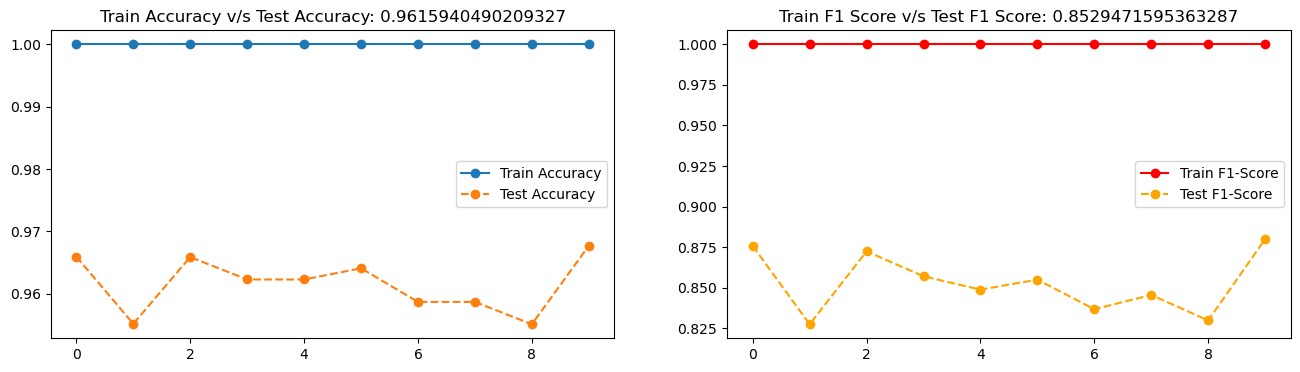

In [117]:
# Compare training & testing accuracy and F1-Score across different folds
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title("Train Accuracy v/s Test Accuracy: %s" %(np.mean(dt_test_accuracy)))
plt.plot(dt_train_accuracy, marker = "o")
plt.plot(dt_test_accuracy, marker = "o", linestyle = "--")
plt.legend(["Train Accuracy", "Test Accuracy"])
plt.subplot(122)
plt.title("Train F1 Score v/s Test F1 Score: %s" %(np.mean(dt_test_f1_score)))
plt.plot(dt_train_f1_score, marker = "o", color = "r")
plt.plot(dt_test_f1_score,  marker = "o", linestyle = "--", color = "orange")
plt.legend(["Train F1-Score", "Test F1-Score"])

### 4) Multinomial Naive Bayes

In [121]:
# Multinomial Naive Bayes
multinom_train_accuracy = []
multinom_test_accuracy = []
multinom_train_f1_score = []
multinom_test_f1_score = []

for train_idx, test_idx in kfold.split(scaled_x, scaled_y):
    x_train, x_test, y_train, y_test = scaled_x[train_idx], scaled_x[test_idx], scaled_y[train_idx], scaled_y[test_idx]
    multinom = MultinomialNB()
    multinom.fit(x_train, y_train)
    train_predict = multinom.predict(x_train)
    test_predict = multinom.predict(x_test)
    
    train_accu = sklearn.metrics.accuracy_score(y_train, train_predict)
    test_accu = sklearn.metrics.accuracy_score(y_test, test_predict)
    
    train_f1 = sklearn.metrics.f1_score(y_train, train_predict)
    test_f1 = sklearn.metrics.f1_score(y_test, test_predict)
    
    multinom_train_accuracy.append(train_accu)
    multinom_test_accuracy.append(test_accu)
    multinom_train_f1_score.append(train_f1)
    multinom_test_f1_score.append(test_f1)

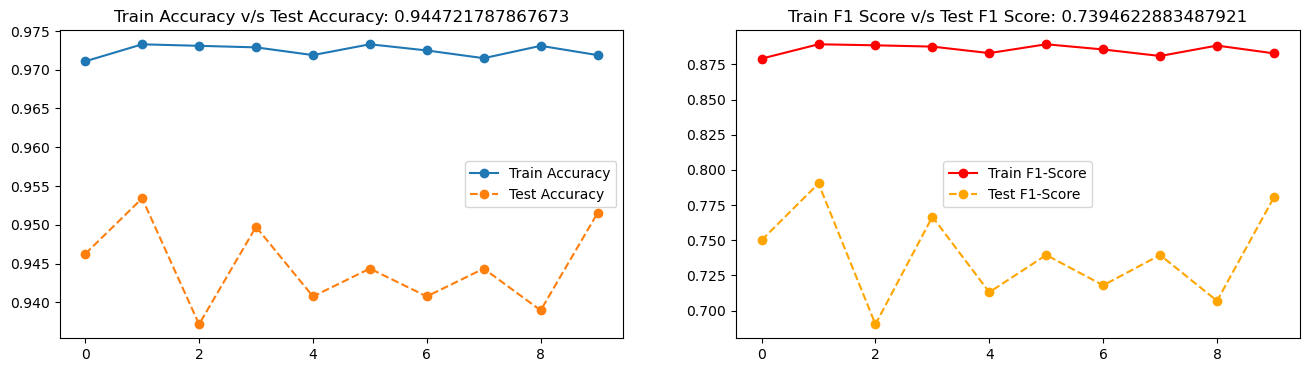

In [123]:
# Compare training & testing accuracy and F1-Score across different folds
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title("Train Accuracy v/s Test Accuracy: %s" %(np.mean(multinom_test_accuracy)))
plt.plot(multinom_train_accuracy, marker = "o")
plt.plot(multinom_test_accuracy, marker = "o", linestyle = "--")
plt.legend(["Train Accuracy", "Test Accuracy"])
plt.subplot(122)
plt.title("Train F1 Score v/s Test F1 Score: %s" %(np.mean(multinom_test_f1_score)))
plt.plot(multinom_train_f1_score, marker = "o", color = "r")
plt.plot(multinom_test_f1_score,  marker = "o", linestyle = "--", color = "orange")
plt.legend(["Train F1-Score", "Test F1-Score"])

### 5) SVM Classifier - Radial Bias Function

In [126]:
# SVM Classifier - Radial Bias Function
svc_classif_train_accuracy = []
svc_classif_test_accuracy = []
svc_classif_train_f1_score = []
svc_classif_test_f1_score = []

for train_idx, test_idx in kfold.split(scaled_x, scaled_y):
    x_train, x_test, y_train, y_test = scaled_x[train_idx], scaled_x[test_idx], scaled_y[train_idx], scaled_y[test_idx]
    svc_classif = SVC(random_state=42)
    svc_classif.fit(x_train, y_train)
    train_predict = svc_classif.predict(x_train)
    test_predict = svc_classif.predict(x_test)
    
    train_accu = sklearn.metrics.accuracy_score(y_train, train_predict)
    test_accu = sklearn.metrics.accuracy_score(y_test, test_predict)
    
    train_f1 = sklearn.metrics.f1_score(y_train, train_predict)
    test_f1 = sklearn.metrics.f1_score(y_test, test_predict)
    
    svc_classif_train_accuracy.append(train_accu)
    svc_classif_test_accuracy.append(test_accu)
    svc_classif_train_f1_score.append(train_f1)
    svc_classif_test_f1_score.append(test_f1)

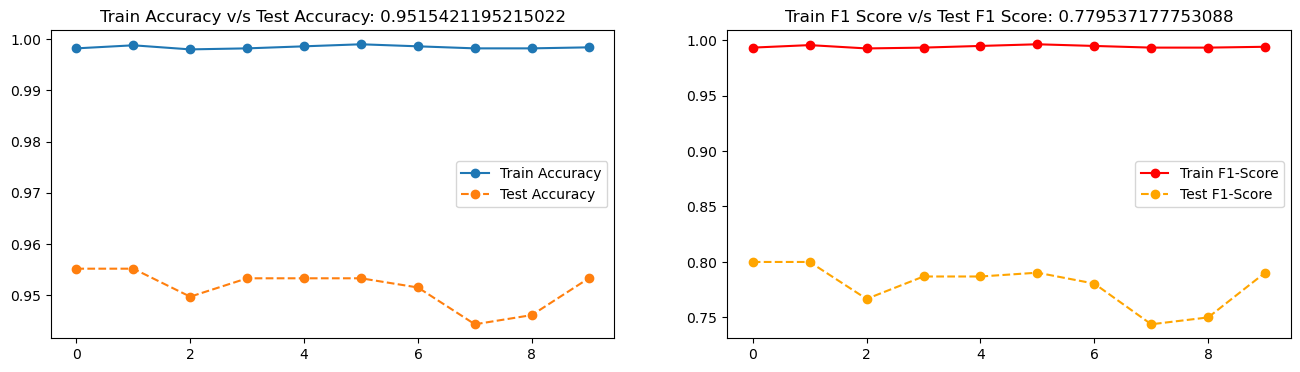

In [127]:
# Compare training & testing accuracy and F1-Score across different folds
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title("Train Accuracy v/s Test Accuracy: %s" %(np.mean(svc_classif_test_accuracy)))
plt.plot(svc_classif_train_accuracy, marker = "o")
plt.plot(svc_classif_test_accuracy, marker = "o", linestyle = "--")
plt.legend(["Train Accuracy", "Test Accuracy"])
plt.subplot(122)
plt.title("Train F1 Score v/s Test F1 Score: %s" %(np.mean(svc_classif_test_f1_score)))
plt.plot(svc_classif_train_f1_score, marker = "o", color = "r")
plt.plot(svc_classif_test_f1_score,  marker = "o", linestyle = "--", color = "orange")
plt.legend(["Train F1-Score", "Test F1-Score"])

### 6) SGD Classifier

In [129]:
# SGD Classifier
sgd_train_accuracy = []
sgd_test_accuracy = []
sgd_train_f1_score = []
sgd_test_f1_score = []

for train_idx, test_idx in kfold.split(scaled_x, scaled_y):
    x_train, x_test, y_train, y_test = scaled_x[train_idx], scaled_x[test_idx], scaled_y[train_idx], scaled_y[test_idx]
    sgd = SGDClassifier(random_state=42)
    sgd.fit(x_train, y_train)
    train_predict = sgd.predict(x_train)
    test_predict = sgd.predict(x_test)
    
    train_accu = sklearn.metrics.accuracy_score(y_train, train_predict)
    test_accu = sklearn.metrics.accuracy_score(y_test, test_predict)
    
    train_f1 = sklearn.metrics.f1_score(y_train, train_predict)
    test_f1 = sklearn.metrics.f1_score(y_test, test_predict)
    
    sgd_train_accuracy.append(train_accu)
    sgd_test_accuracy.append(test_accu)
    sgd_train_f1_score.append(train_f1)
    sgd_test_f1_score.append(test_f1)

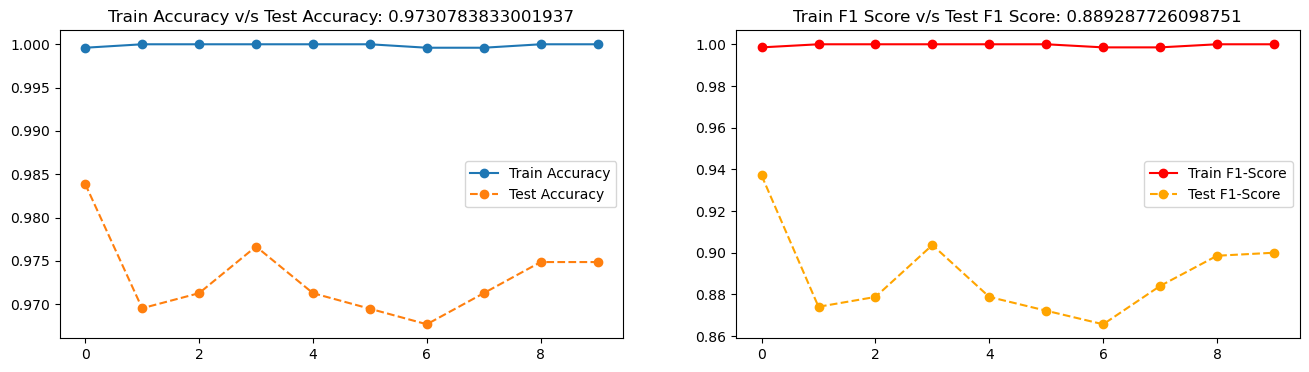

In [130]:
# Compare training & testing accuracy and F1-Score across different folds
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title("Train Accuracy v/s Test Accuracy: %s" %(np.mean(sgd_test_accuracy)))
plt.plot(sgd_train_accuracy, marker = "o")
plt.plot(sgd_test_accuracy, marker = "o", linestyle = "--")
plt.legend(["Train Accuracy", "Test Accuracy"])
plt.subplot(122)
plt.title("Train F1 Score v/s Test F1 Score: %s" %(np.mean(sgd_test_f1_score)))
plt.plot(sgd_train_f1_score, marker = "o", color = "r")
plt.plot(sgd_test_f1_score,  marker = "o", linestyle = "--", color = "orange")
plt.legend(["Train F1-Score", "Test F1-Score"])

### 7) Ridge Classifier

In [136]:
# Ridge Classifier
ridge_classif_train_accuracy = []
ridge_classif_test_accuracy = []
ridge_classif_train_f1_score = []
ridge_classif_test_f1_score = []

for train_idx, test_idx in kfold.split(scaled_x, scaled_y):
    x_train, x_test, y_train, y_test = scaled_x[train_idx], scaled_x[test_idx], scaled_y[train_idx], scaled_y[test_idx]
    ridge_classif = RidgeClassifier(random_state=42)
    ridge_classif.fit(x_train, y_train)
    train_predict = ridge_classif.predict(x_train)
    test_predict = ridge_classif.predict(x_test)
    
    train_accu = sklearn.metrics.accuracy_score(y_train, train_predict)
    test_accu = sklearn.metrics.accuracy_score(y_test, test_predict)
    
    train_f1 = sklearn.metrics.f1_score(y_train, train_predict)
    test_f1 = sklearn.metrics.f1_score(y_test, test_predict)
    
    ridge_classif_train_accuracy.append(train_accu)
    ridge_classif_test_accuracy.append(test_accu)
    ridge_classif_train_f1_score.append(train_f1)
    ridge_classif_test_f1_score.append(test_f1)

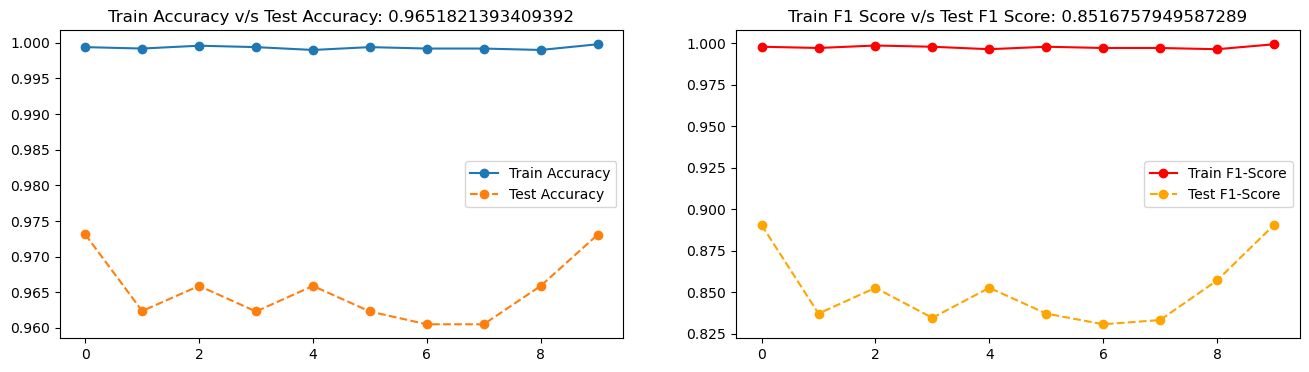

In [138]:
# Compare training & testing accuracy and F1-Score across different folds
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.title("Train Accuracy v/s Test Accuracy: %s" %(np.mean(ridge_classif_test_accuracy)))
plt.plot(ridge_classif_train_accuracy, marker = "o")
plt.plot(ridge_classif_test_accuracy, marker = "o", linestyle = "--")
plt.legend(["Train Accuracy", "Test Accuracy"])
plt.subplot(122)
plt.title("Train F1 Score v/s Test F1 Score: %s" %(np.mean(ridge_classif_test_f1_score)))
plt.plot(ridge_classif_train_f1_score, marker = "o", color = "r")
plt.plot(ridge_classif_test_f1_score,  marker = "o", linestyle = "--", color = "orange")
plt.legend(["Train F1-Score", "Test F1-Score"])

In [140]:
train_accuracy_score = pd.DataFrame([lr_train_accuracy, knn_train_accuracy, dt_train_accuracy, multinom_train_accuracy, svc_classif_train_accuracy, sgd_train_accuracy, ridge_classif_train_accuracy], index = ["Logistic", "KNN", "DecisionTree", "Multinom Bayes", "SVM", "SGD", "Ridge"])
test_accuracy_score = pd.DataFrame([lr_test_accuracy, knn_test_accuracy, dt_test_accuracy, multinom_test_accuracy, svc_classif_test_accuracy, sgd_test_accuracy, ridge_classif_train_accuracy], index = ["Logistic", "KNN", "DecisionTree", "Multinom Bayes", "SVM", "SGD", "Ridge"])
train_f1_score = pd.DataFrame([lr_train_f1_score, knn_train_f1_score, dt_train_f1_score, multinom_train_f1_score, svc_classif_train_f1_score, sgd_train_f1_score, ridge_classif_train_accuracy], index = ["Logistic", "KNN", "DecisionTree", "Multinom Bayes", "SVM", "SGD", "Ridge"])
test_f1_score = pd.DataFrame([lr_test_f1_score, knn_test_f1_score, dt_test_f1_score, multinom_test_f1_score, svc_classif_test_f1_score, sgd_test_f1_score, ridge_classif_train_f1_score], index = ["Logistic", "KNN", "DecisionTree", "Multinom Bayes", "SVM", "SGD", "Ridge"])

In [142]:
# Apply column layout styling
CSS = """
.output {
    flex-direction: column;
}
"""

HTML('<style>{}</style>'.format(CSS))

In [144]:
# Generate matrices which compare the accuracy / scores across the 7 models and various folds
display(Markdown('## Train Accuracy across 10-Folds'))
display(train_accuracy_score.style.background_gradient(cmap = "Blues"), display_id = 'train_acc')
display(Markdown('## Test Accuracy across 10-Folds'))
display(test_accuracy_score.style.background_gradient(cmap = "Blues"), display_id = 'test_acc')
display(Markdown('## Train F1-Score across 10-Folds'))
display(train_f1_score.style.background_gradient(cmap = "Blues"), display_id = 'train_f1_score')
display(Markdown('## Test F1-Score across 10-Folds'))
display(test_f1_score.style.background_gradient(cmap = "Blues"), display_id = 'test_f1_score')

## Train Accuracy across 10-Folds

,0,1,2,3,4,5,6,7,8,9
Logistic,0.943359,0.941364,0.943370,0.943170,0.942971,0.942173,0.944367,0.944766,0.944367,0.942971
KNN,0.912046,0.912246,0.912263,0.912463,0.911665,0.910867,0.914457,0.914058,0.914457,0.913061
DecisionTree,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Multinom Bayes,0.971081,0.973275,0.973081,0.972881,0.971884,0.973280,0.972483,0.971486,0.973081,0.971884
SVM,0.998205,0.998803,0.998006,0.998205,0.998604,0.999003,0.998604,0.998205,0.998205,0.998405
SGD,0.999601,1.000000,1.000000,1.000000,1.000000,1.000000,0.999601,0.999601,1.000000,1.000000
Ridge,0.999402,0.999202,0.999601,0.999402,0.999003,0.999402,0.999202,0.999202,0.999003,0.999801


## Test Accuracy across 10-Folds

,0,1,2,3,4,5,6,7,8,9
Logistic,0.928315,0.935484,0.913824,0.919210,0.919210,0.931777,0.917415,0.922801,0.917415,0.929982
KNN,0.894265,0.894265,0.897666,0.899461,0.895871,0.901257,0.894075,0.899461,0.899461,0.908438
DecisionTree,0.965950,0.955197,0.965889,0.962298,0.962298,0.964093,0.958707,0.958707,0.955117,0.967684
Multinom Bayes,0.946237,0.953405,0.937163,0.949731,0.940754,0.944345,0.940754,0.944345,0.938959,0.951526
SVM,0.955197,0.955197,0.949731,0.953321,0.953321,0.953321,0.951526,0.944345,0.946140,0.953321
SGD,0.983871,0.969534,0.971275,0.976661,0.971275,0.969479,0.967684,0.971275,0.974865,0.974865
Ridge,0.999402,0.999202,0.999601,0.999402,0.999003,0.999402,0.999202,0.999202,0.999003,0.999801


## Train F1-Score across 10-Folds

,0,1,2,3,4,5,6,7,8,9
Logistic,0.733083,0.721591,0.734082,0.732896,0.731707,0.726415,0.739008,0.741363,0.739496,0.731203
KNN,0.511628,0.513274,0.514349,0.515987,0.509413,0.501672,0.531148,0.527930,0.531148,0.519824
DecisionTree,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Multinom Bayes,0.879066,0.889256,0.888522,0.887603,0.882988,0.889256,0.885572,0.880933,0.888337,0.882793
SVM,0.993258,0.995516,0.992515,0.993269,0.994772,0.996266,0.994764,0.993258,0.993258,0.994012
SGD,0.998514,1.000000,1.000000,1.000000,1.000000,1.000000,0.998514,0.998514,1.000000,1.000000
Ridge,0.999402,0.999202,0.999601,0.999402,0.999003,0.999402,0.999202,0.999202,0.999003,0.999801


## Test F1-Score across 10-Folds

,0,1,2,3,4,5,6,7,8,9
Logistic,0.642857,0.684211,0.520000,0.563107,0.563107,0.660714,0.566038,0.612613,0.557692,0.648649
KNN,0.351648,0.351648,0.373626,0.391304,0.355556,0.421053,0.351648,0.404255,0.404255,0.484848
DecisionTree,0.875817,0.827586,0.872483,0.857143,0.848921,0.855072,0.836879,0.845638,0.829932,0.880000
Multinom Bayes,0.750000,0.790323,0.690265,0.766667,0.713043,0.739496,0.717949,0.739496,0.706897,0.780488
SVM,0.800000,0.800000,0.766667,0.786885,0.786885,0.790323,0.780488,0.743802,0.750000,0.790323
SGD,0.937063,0.874074,0.878788,0.903704,0.878788,0.872180,0.865672,0.884058,0.898551,0.900000
Ridge,0.997770,0.997028,0.998512,0.997766,0.996288,0.997773,0.997024,0.997024,0.996283,0.999255


<DisplayHandle display_id=test_f1_score>

In [146]:
# Calculate average scores for each model
model_avg_scores = {'model': [], "train_accuracy": [], "test_accuracy": [], "train_f1": [], "test_f1": []}

for idx1, row1 in train_accuracy_score.iterrows():
    model_avg_scores["model"].append(idx1)
    model_avg_scores['train_accuracy'].append(np.mean(row1))
    
for idx2, row2 in test_accuracy_score.iterrows():
    model_avg_scores['test_accuracy'].append(np.mean(row2))
    
for idx3, row3 in train_f1_score.iterrows():
    model_avg_scores['train_f1'].append(np.mean(row3))
    
for idx4, row4 in test_f1_score.iterrows():
    model_avg_scores['test_f1'].append(np.mean(row4))

In [148]:
# Create a dataframe of the model_avg_scores dictionary
model_score_df = pd.DataFrame(model_avg_scores)

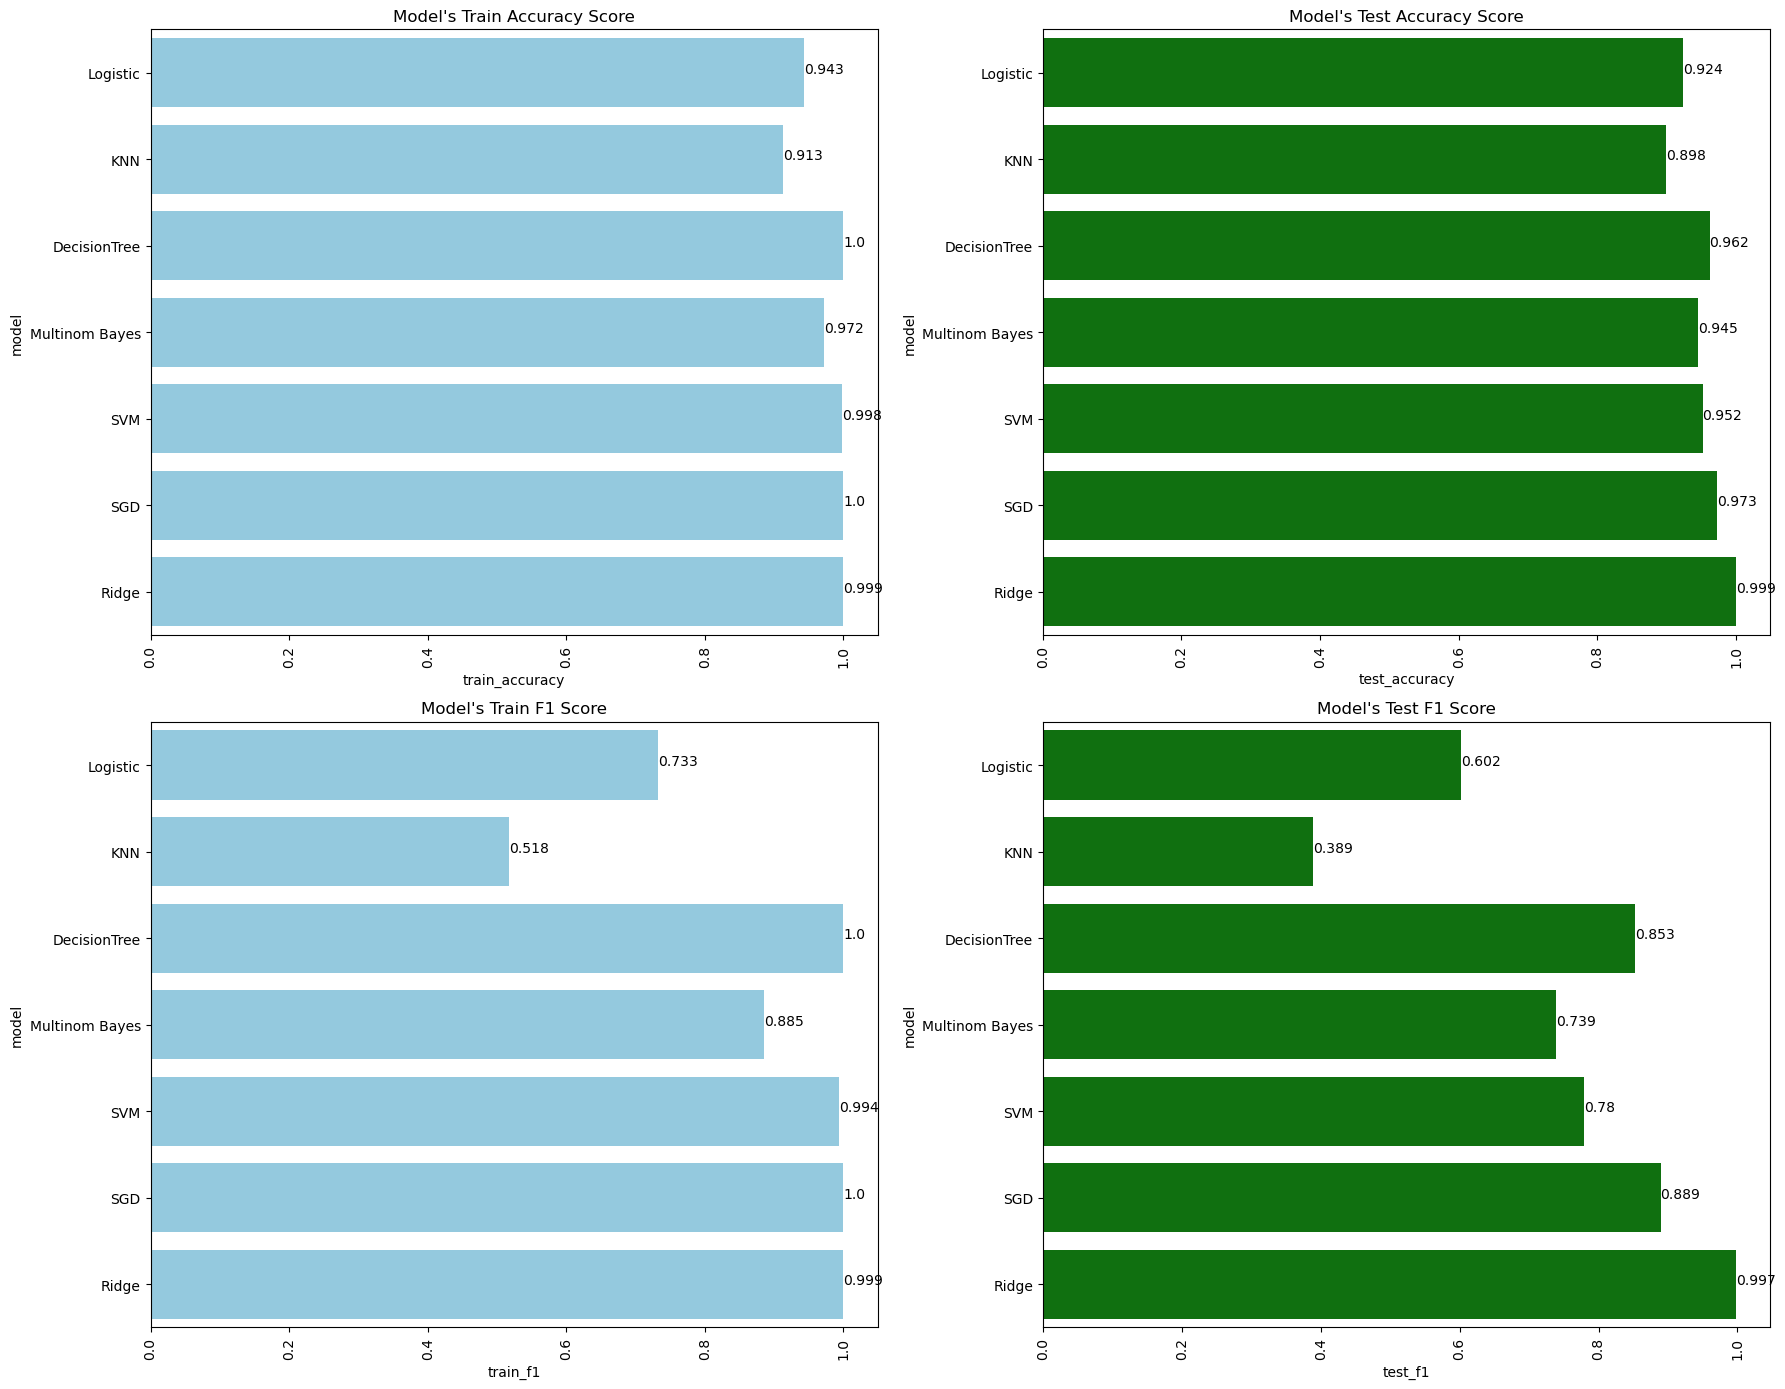

In [150]:
# Plot and compare each model's accuracy and F1 score in bar graphs
plt.figure(figsize=(18,14))
plt.subplot(221)
plt.title("Model's Train Accuracy Score")
sns.barplot(x = model_score_df["train_accuracy"], y = model_score_df.model, color = "skyblue")
plt.xticks(rotation = 90)
for idx, val in enumerate(model_score_df.train_accuracy):
    plt.text(val, idx, round(float(val),3))
plt.subplot(222)
plt.title("Model's Test Accuracy Score")
sns.barplot(x = model_score_df["test_accuracy"], y = model_score_df.model, color = "g")
plt.xticks(rotation = 90)
for idx, val in enumerate(model_score_df.test_accuracy):
    plt.text(val, idx, round(float(val),3))
plt.subplot(223)
plt.title("Model's Train F1 Score")
sns.barplot(x = model_score_df["train_f1"], y = model_score_df.model, color = "skyblue")
plt.xticks(rotation = 90)
for idx, val in enumerate(model_score_df.train_f1):
    plt.text(val, idx, round(float(val),3))
plt.subplot(224)
plt.title("Model's Test F1 Score")
sns.barplot(x = model_score_df["test_f1"], y = model_score_df.model, color = "g")
plt.xticks(rotation = 90)
for idx, val in enumerate(model_score_df.test_f1):
    plt.text(val, idx, round(float(val),3))
plt.tight_layout()
plt.show()

### [Analysis] As observed in the results above, the KNN algorithm exhibits suboptimal performance when dealing with imbalanced datasets. Although the accuracy of KNN appears reasonably high, a closer examination of the F1 score reveals underwhelming performance. This underscores the limitation of relying solely on accuracy in the presence of class imbalance. Despite presenting accuracy for metric comparison in the case of an imbalanced dataset, it is evident that F1 score provides a more meaningful assessment.

### For our upcoming hyperparameter optimization, I would recommend considering the Ridge Classifier as a top algorithm.

In [154]:
# View the dataframe containing each model's average accuracy and F1 scores
model_score_df.style.background_gradient(cmap = "Blues_r")

,model,train_accuracy,test_accuracy,train_f1,test_f1
0,Logistic,0.943288,0.923543,0.733084,0.601899
1,KNN,0.912758,0.898422,0.517637,0.388984
2,DecisionTree,1.000000,0.961594,1.000000,0.852947
3,Multinom Bayes,0.972442,0.944722,0.885433,0.739462
4,SVM,0.998425,0.951542,0.994089,0.779537
5,SGD,0.999880,0.973078,0.999554,0.889288
6,Ridge,0.999322,0.999322,0.999322,0.997472


### Hyperparameter Optimization

### In this segment, we will conduct hyperparameter optimization to assess the performance of our top model, Ridge Classifier. Our objective is to explore whether manual iteration on the model's parameters can lead to further improvement.

In [170]:
# Iterate over a range of values for parameters such as 'alpha', 'fit_intercept', 'tol', 'class_weight', and 'max_iter'. By considering different combinations within these parameter spaces, our goal is to fine-tune the model for optimal performance.
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score

ridge_params = {
    'alpha': [1.0,0.1,0.001,0.0001,0.5,0.005,0.0005,10,25,50,75],
    'fit_intercept': [True, False],
    'tol': [0.001,0.01,0.1,0.005,0.05,0.5,0.2,0.02,0.002],
    'class_weight': ['balanced'],
    'max_iter': [100,500,1000, False]
}

In [172]:
# Create a Ridge Classifier object for tuning hyperparameters and evaluating the model's performance.
ridge_classifier_hp = RidgeClassifier(random_state = 0)

In [174]:
# Set up a randomized search cross-validation for exploring hyperparameter combinations 
ridge_random_search = RandomizedSearchCV(estimator=ridge_classifier_hp, param_distributions=ridge_params, cv = 10, scoring = 'f1', random_state = 42, verbose = 0)

In [176]:
# Initiate the Ridge Classifier's Randomized Search with the training data
ridge_random_search.fit(x_train, y_train)

RandomizedSearchCV(cv=10, estimator=RidgeClassifier(random_state=0),
                   param_distributions={'alpha': [1.0, 0.1, 0.001, 0.0001, 0.5,
                                                  0.005, 0.0005, 10, 25, 50,
                                                  75],
                                        'class_weight': ['balanced'],
                                        'fit_intercept': [True, False],
                                        'max_iter': [100, 500, 1000, False],
                                        'tol': [0.001, 0.01, 0.1, 0.005, 0.05,
                                                0.5, 0.2, 0.02, 0.002]},
                   random_state=42, scoring='f1')

In [177]:
# Identify the best-performing estimator during the hyperparameter optimization process
ridge_random_search.best_estimator_

RidgeClassifier(alpha=0.1, class_weight='balanced', fit_intercept=False,
                max_iter=500, random_state=0, tol=0.005)

In [180]:
# Determine the best cross-validated F1 score
ridge_random_search.best_score_

0.9191808372217872

In [181]:
# Obtain predictions from the best estimator found during the hyperparameter search
ridge_ytrain_predict = ridge_random_search.predict(x_train)
ridge_ytest_predict = ridge_random_search.predict(x_test)

In [184]:
evaluate_model(y_train, y_test, ridge_ytrain_predict, ridge_ytest_predict)

*******Accuracy*******

Train Accuracy: 1.0
Test Accuracy: 0.9820466786355476


Train Error: 0.0
Test Error: 0.01795332136445238

******* F1-Score **********


Train F1-Score: 1.0
Test F1-Score: 0.9333333333333333

********* Log Loss ***********


Train Log Loss: 2.2204460492503136e-16
Test Log Loss: 0.6471032924437553

********* Classification Report *********


Train Classification Report:
                0      1  accuracy  macro avg  weighted avg
precision     1.0    1.0       1.0        1.0           1.0
recall        1.0    1.0       1.0        1.0           1.0
f1-score      1.0    1.0       1.0        1.0           1.0
support    4343.0  672.0       1.0     5015.0        5015.0
Test Classification Report:
                    0          1  accuracy  macro avg  weighted avg
precision    0.989627   0.933333  0.982047    0.96148      0.982047
recall       0.989627   0.933333  0.982047    0.96148      0.982047
f1-score     0.989627   0.933333  0.982047    0.96148      0.982047
suppo

### [Analysis] Hyperparameter Tuning Results

### Following the hyperparameter tuning process, our Ridge Classifier has demonstrated good performance in predictive accuracy, particularly in minimizing false positives. To enhance the precision of our model, we will proceed with a Grid Search CV on the parameters identified through the randomized search cross-validation, aiming for further refinement.

### Grid Search Cross Validation - Ridge Classifier

In [188]:
# As a refresher, here's the best-performing estimator during the hyperparameter optimization process
# RidgeClassifier(alpha=0.1, class_weight='balanced', fit_intercept=False, max_iter=500, random_state=0, tol=0.005)

In [190]:
# Create set of hyperparameters used in Grid Search CV to further fine-tune our Ridge Classifier model
grid_params = {
    
    'alpha': [0.1,0.5,0.75,1],
    'max_iter': [100,300,500],
    'tol': [0.01,0.05,0.1,1,5]
}

In [191]:
# Initialize RidgeClassifier 
ridge = RidgeClassifier(random_state=0, class_weight='balanced')

In [194]:
# Set up a Grid Search for hyperparameter tuning using a Ridge Classifier. 
grid_search = GridSearchCV(estimator=ridge, param_grid = grid_params, scoring = 'f1', cv = 10)

In [196]:
# Fit the Grid Search to training data and find the best hyperparameters for the Ridge Classifier
best_model = grid_search.fit(x_train, y_train)

In [197]:
# Provide the best estimator
best_model.best_estimator_

RidgeClassifier(alpha=1, class_weight='balanced', max_iter=100, random_state=0,
                tol=0.1)

In [198]:
# Provide the set of hyperparameters 
best_model.best_params_

{'alpha': 1, 'max_iter': 100, 'tol': 0.1}

In [199]:
# Provide the average cross-validated F1 score achieved by the best_estimator
best_model.best_score_

0.8973548346342474

Text(0, 0.5, 'Mean Test Score')

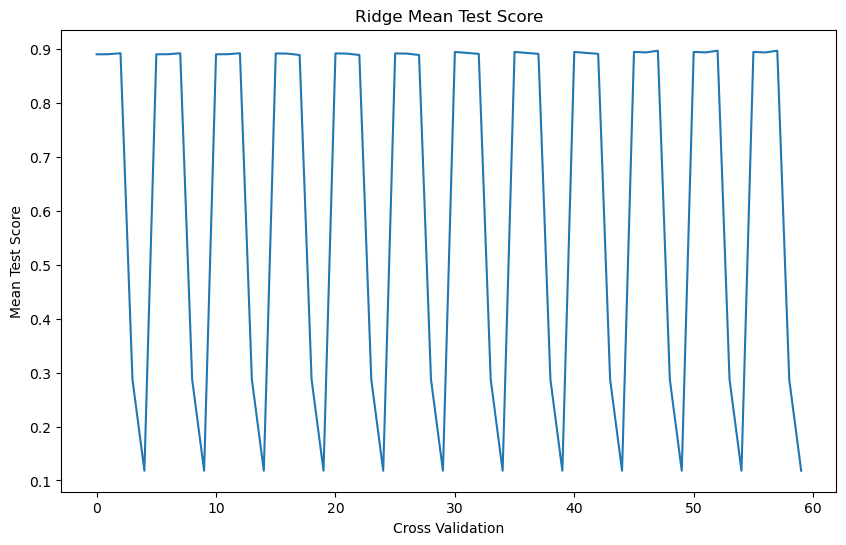

In [200]:
# Plot the mean test score across different cross-validation folds for the Ridge Classifier during the grid search
plt.figure(figsize=(10,6))
plt.title("Ridge Mean Test Score")
plt.plot(best_model.cv_results_["mean_test_score"])
plt.xlabel("Cross Validation")
plt.ylabel("Mean Test Score")

In [201]:
# Use the best model obtained from the grid search to make predictions on both the training and test sets
train_predict = best_model.predict(x_train)
test_predict = best_model.predict(x_test)

In [202]:
# Evaluate the best model
evaluate_model(y_train, y_test, train_predict, test_predict)

*******Accuracy*******

Train Accuracy: 0.9994017946161515
Test Accuracy: 0.9802513464991023


Train Error: 0.0005982053838484713
Test Error: 0.019748653500897717

******* F1-Score **********


Train F1-Score: 0.9977728285077951
Test F1-Score: 0.9230769230769231

********* Log Loss ***********


Train Log Loss: 0.021561507510937702
Test Log Loss: 0.7118136216881307

********* Classification Report *********


Train Classification Report:
                     0           1  accuracy    macro avg  weighted avg
precision     1.000000    0.995556  0.999402     0.997778      0.999404
recall        0.999309    1.000000  0.999402     0.999655      0.999402
f1-score      0.999654    0.997773  0.999402     0.998714      0.999402
support    4343.000000  672.000000  0.999402  5015.000000   5015.000000
Test Classification Report:
                    0          1  accuracy   macro avg  weighted avg
precision    0.981595   0.970588  0.980251    0.976092      0.980113
recall       0.995851   0.880000

### Final Model

In [211]:
# Initialize final RidgeClassifier 
f_ridge =  RidgeClassifier(alpha=75, class_weight='balanced', max_iter=500, random_state=0, tol=0.01)

In [213]:
# Fit the training data for the final Ridge Classifier
f_ridge.fit(x_train, y_train)

RidgeClassifier(alpha=75, class_weight='balanced', max_iter=500, random_state=0,
                tol=0.01)

In [215]:
# Make predictions on the training set
train_final_prediction = f_ridge.predict(x_train)

In [217]:
# Make predictions on the testing set
test_final_prediction = f_ridge.predict(x_test)

In [219]:
# Create dataframes to hold the predictions on the training and test sets
train_predict_df = pd.DataFrame(train_final_prediction)
test_predict_df = pd.DataFrame(test_final_prediction)


In [221]:
# Combine predictions from the training and test sets into a single dataframe 
final_prediction = pd.concat([train_predict_df, test_predict_df]).reset_index(drop=True)

In [223]:
# Select first 2 columns
final_df = df.iloc[:, :2]

In [225]:
# Add a new column named "class_predict" to the final_df dataframe and populate it with the predictions
final_df["class_predict"] = final_prediction

In [227]:
# Define class mapping dictionary of spam and ham
class_mapping = {0: "ham", 1:"spam"}

In [229]:
# Convert numerical class labels back to their corresponding categorical labels
final_df.class_predict = final_df.class_predict.map(class_mapping)

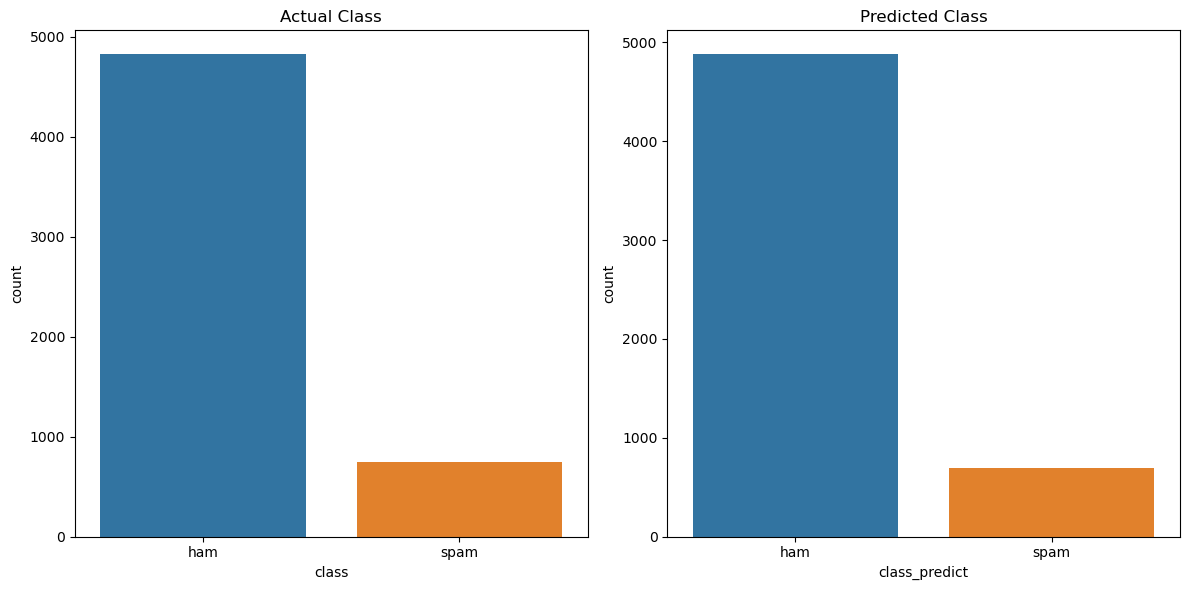

In [231]:
# Creating side-by-side comparison of the actual class distribution and the predicted class distribution; provide insights to final model's performance

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title("Actual Class")
sns.countplot(data=final_df, x="class")
plt.subplot(122)
plt.title("Predicted Class")
sns.countplot(data=final_df, x="class_predict")
plt.tight_layout()